In [344]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error

df = pd.read_csv("train.csv")

Я пишу все в фунциях чтобы легче было преобразовывать тестовую выборку.\
Преобразовываем дату.

In [345]:
def date_refactor(df):
    df['ApplicationDate'] = pd.to_datetime(df['ApplicationDate'], format='%Y-%m-%d')
    df['year'] = df['ApplicationDate'].dt.year
    df['month'] = df['ApplicationDate'].dt.month
    df['day'] = df['ApplicationDate'].dt.day
    df = df.drop('ApplicationDate', axis=1)
    return df

Используем One-Hot Encoding для категориальных признаков

In [346]:
def one_hot_encoding(df):
    return pd.get_dummies(df, columns=['MaritalStatus', 'HomeOwnershipStatus', 'EmploymentStatus', 'EducationLevel', 'LoanPurpose'], drop_first=True)

Посмотрим корреляционную матрицу

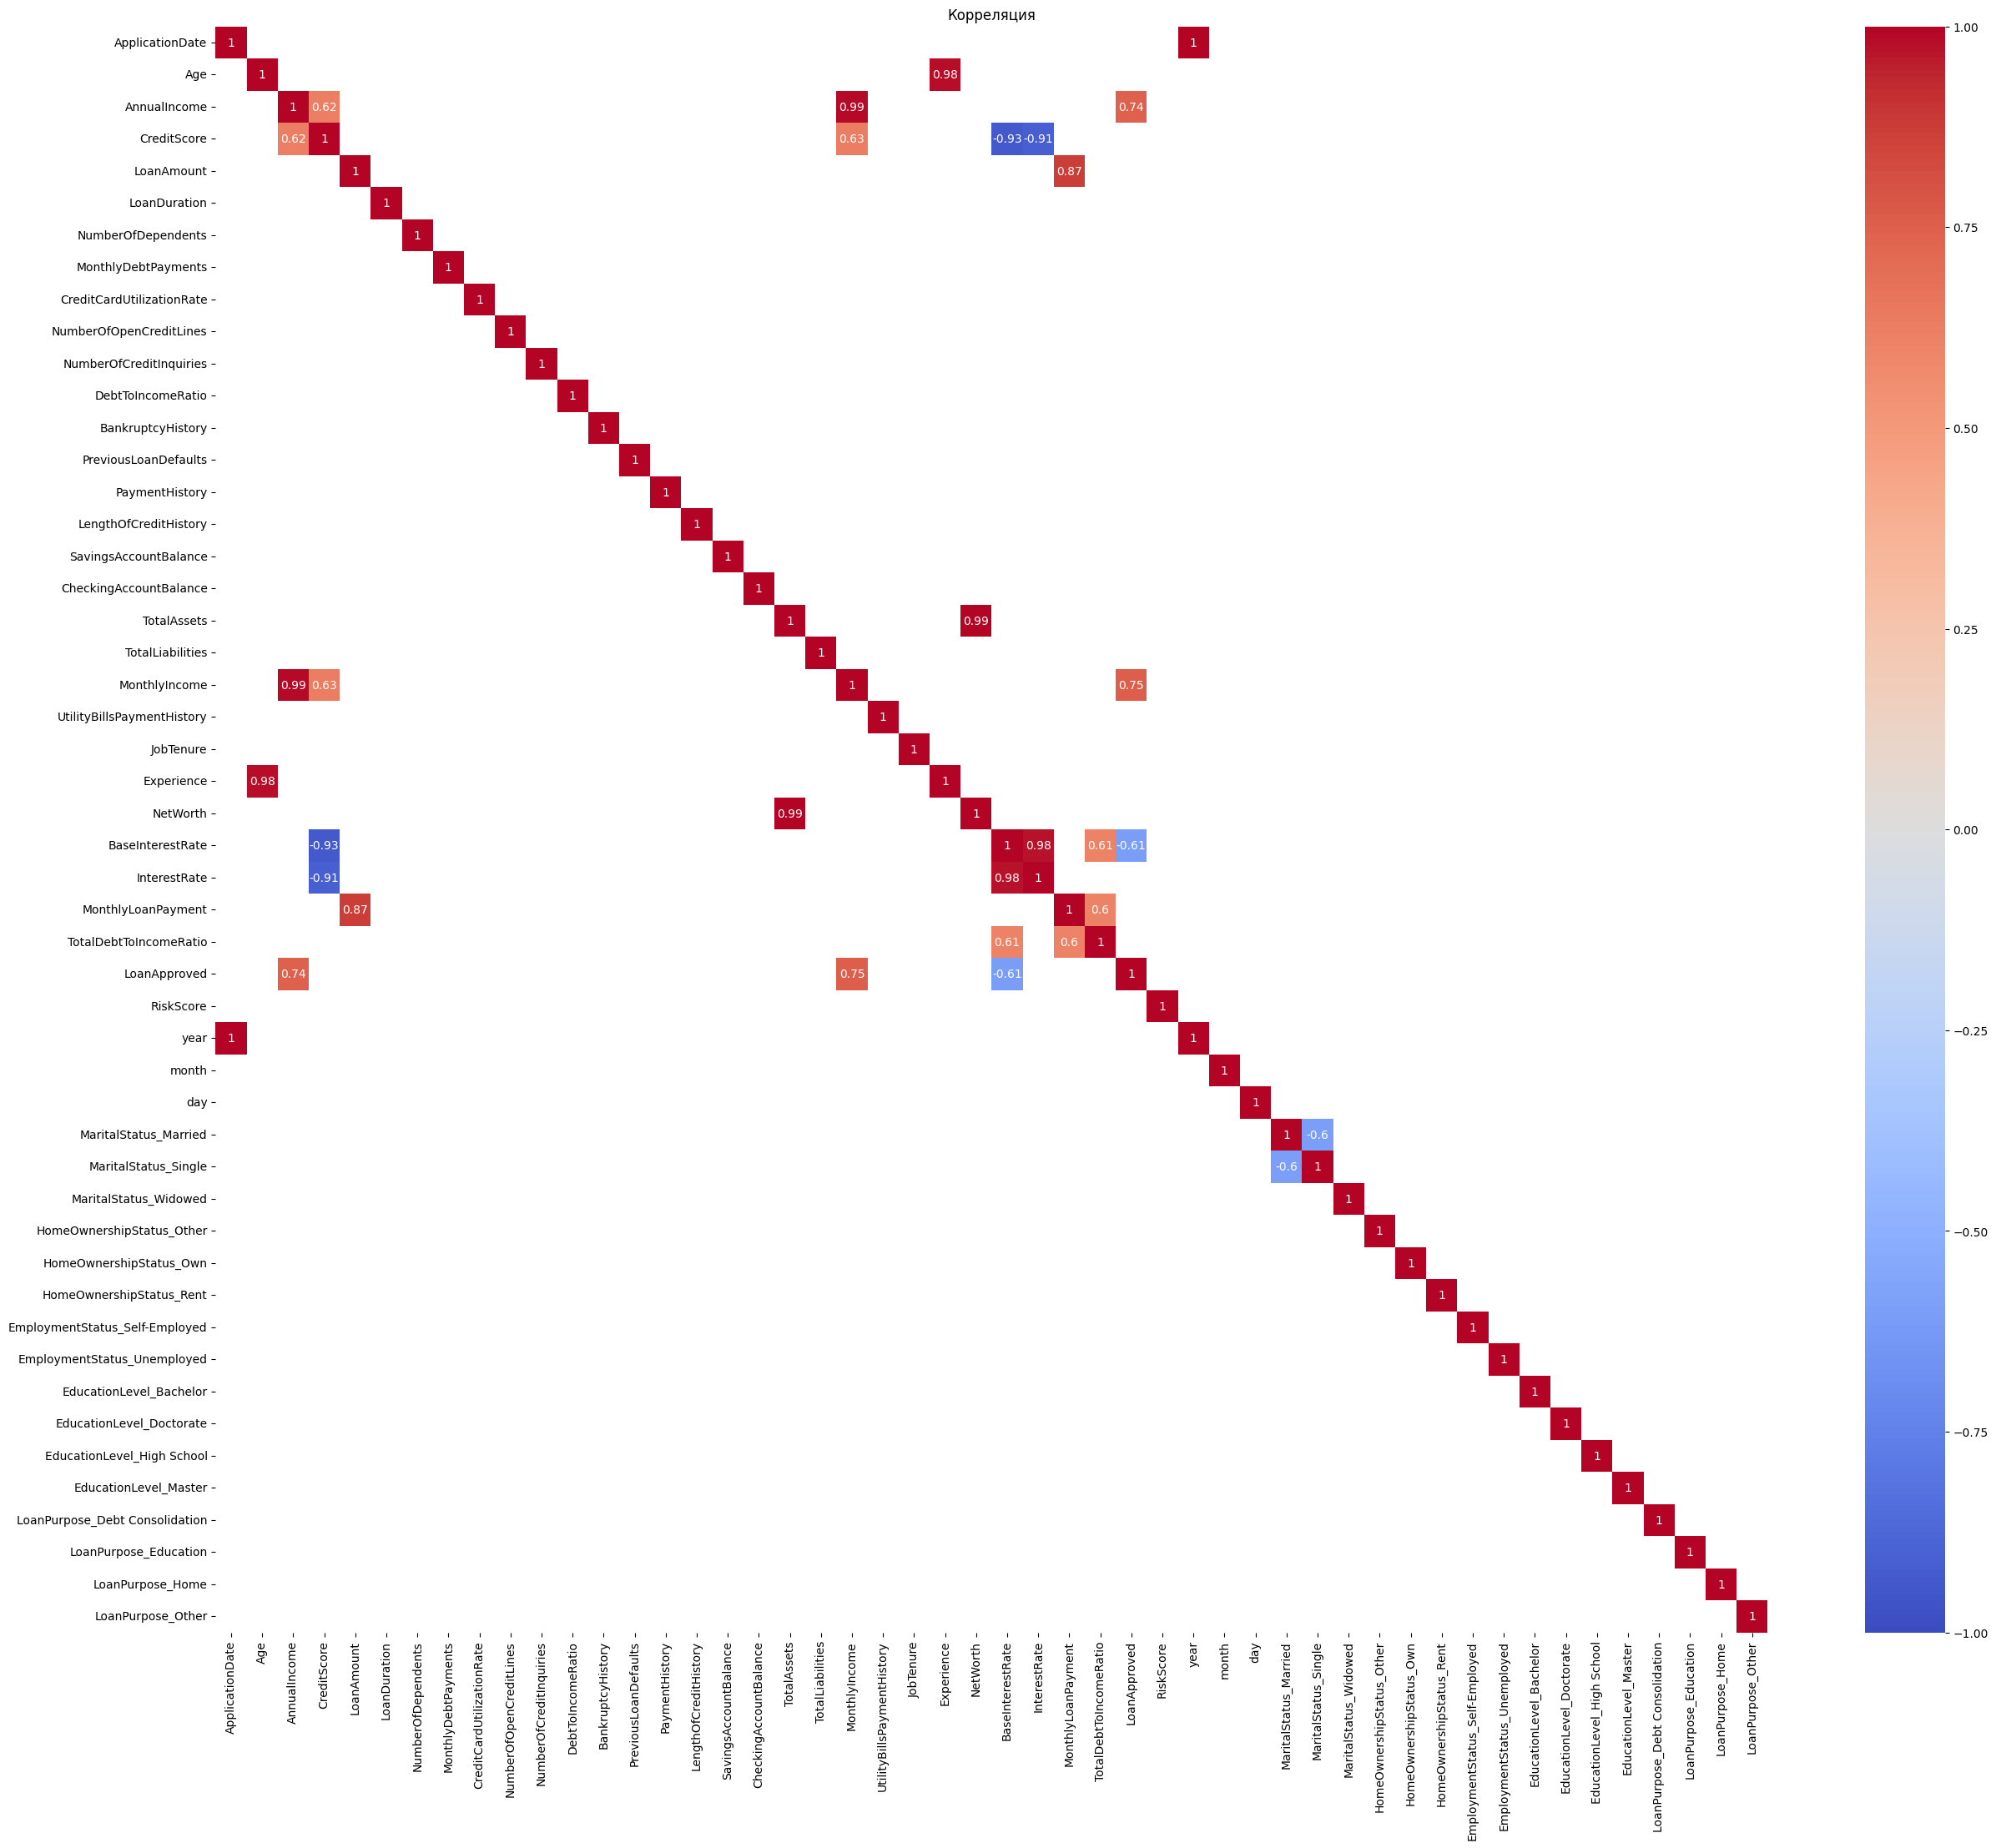

In [347]:
df_corr = date_refactor(df)
df_corr = one_hot_encoding(df)
correlation = df_corr.corr()
plt.figure(figsize=(30, 25))
sns.heatmap(correlation[correlation.abs() >= 0.6], annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Корреляция")
plt.show()

Удаляем только сильно коррелирующие признаки. Также не трогаем категориальные признаки.

In [348]:
big_corr = correlation[(correlation.abs() >= 0.7) & (correlation != 1.0)].stack()
print(high_corr)

def drop_corr(df):
    return df.drop(['Experience', 'MonthlyIncome', 'AnnualIncome',
                    'InterestRate', 'BaseInterestRate', 'MonthlyLoanPayment', 'TotalAssets'], axis = 1)

ApplicationDate     year                  0.999701
Age                 Experience            0.982995
AnnualIncome        MonthlyIncome         0.985384
                    LoanApproved          0.743034
CreditScore         BaseInterestRate     -0.931766
                    InterestRate         -0.907621
LoanAmount          MonthlyLoanPayment    0.872539
TotalAssets         NetWorth              0.994042
MonthlyIncome       AnnualIncome          0.985384
                    LoanApproved          0.754853
Experience          Age                   0.982995
NetWorth            TotalAssets           0.994042
BaseInterestRate    CreditScore          -0.931766
                    InterestRate          0.975359
InterestRate        CreditScore          -0.907621
                    BaseInterestRate      0.975359
MonthlyLoanPayment  LoanAmount            0.872539
LoanApproved        AnnualIncome          0.743034
                    MonthlyIncome         0.754853
year                Application

Создаем гистограммы, чтобы понять, какую нормализацию стоит использовать для признаков

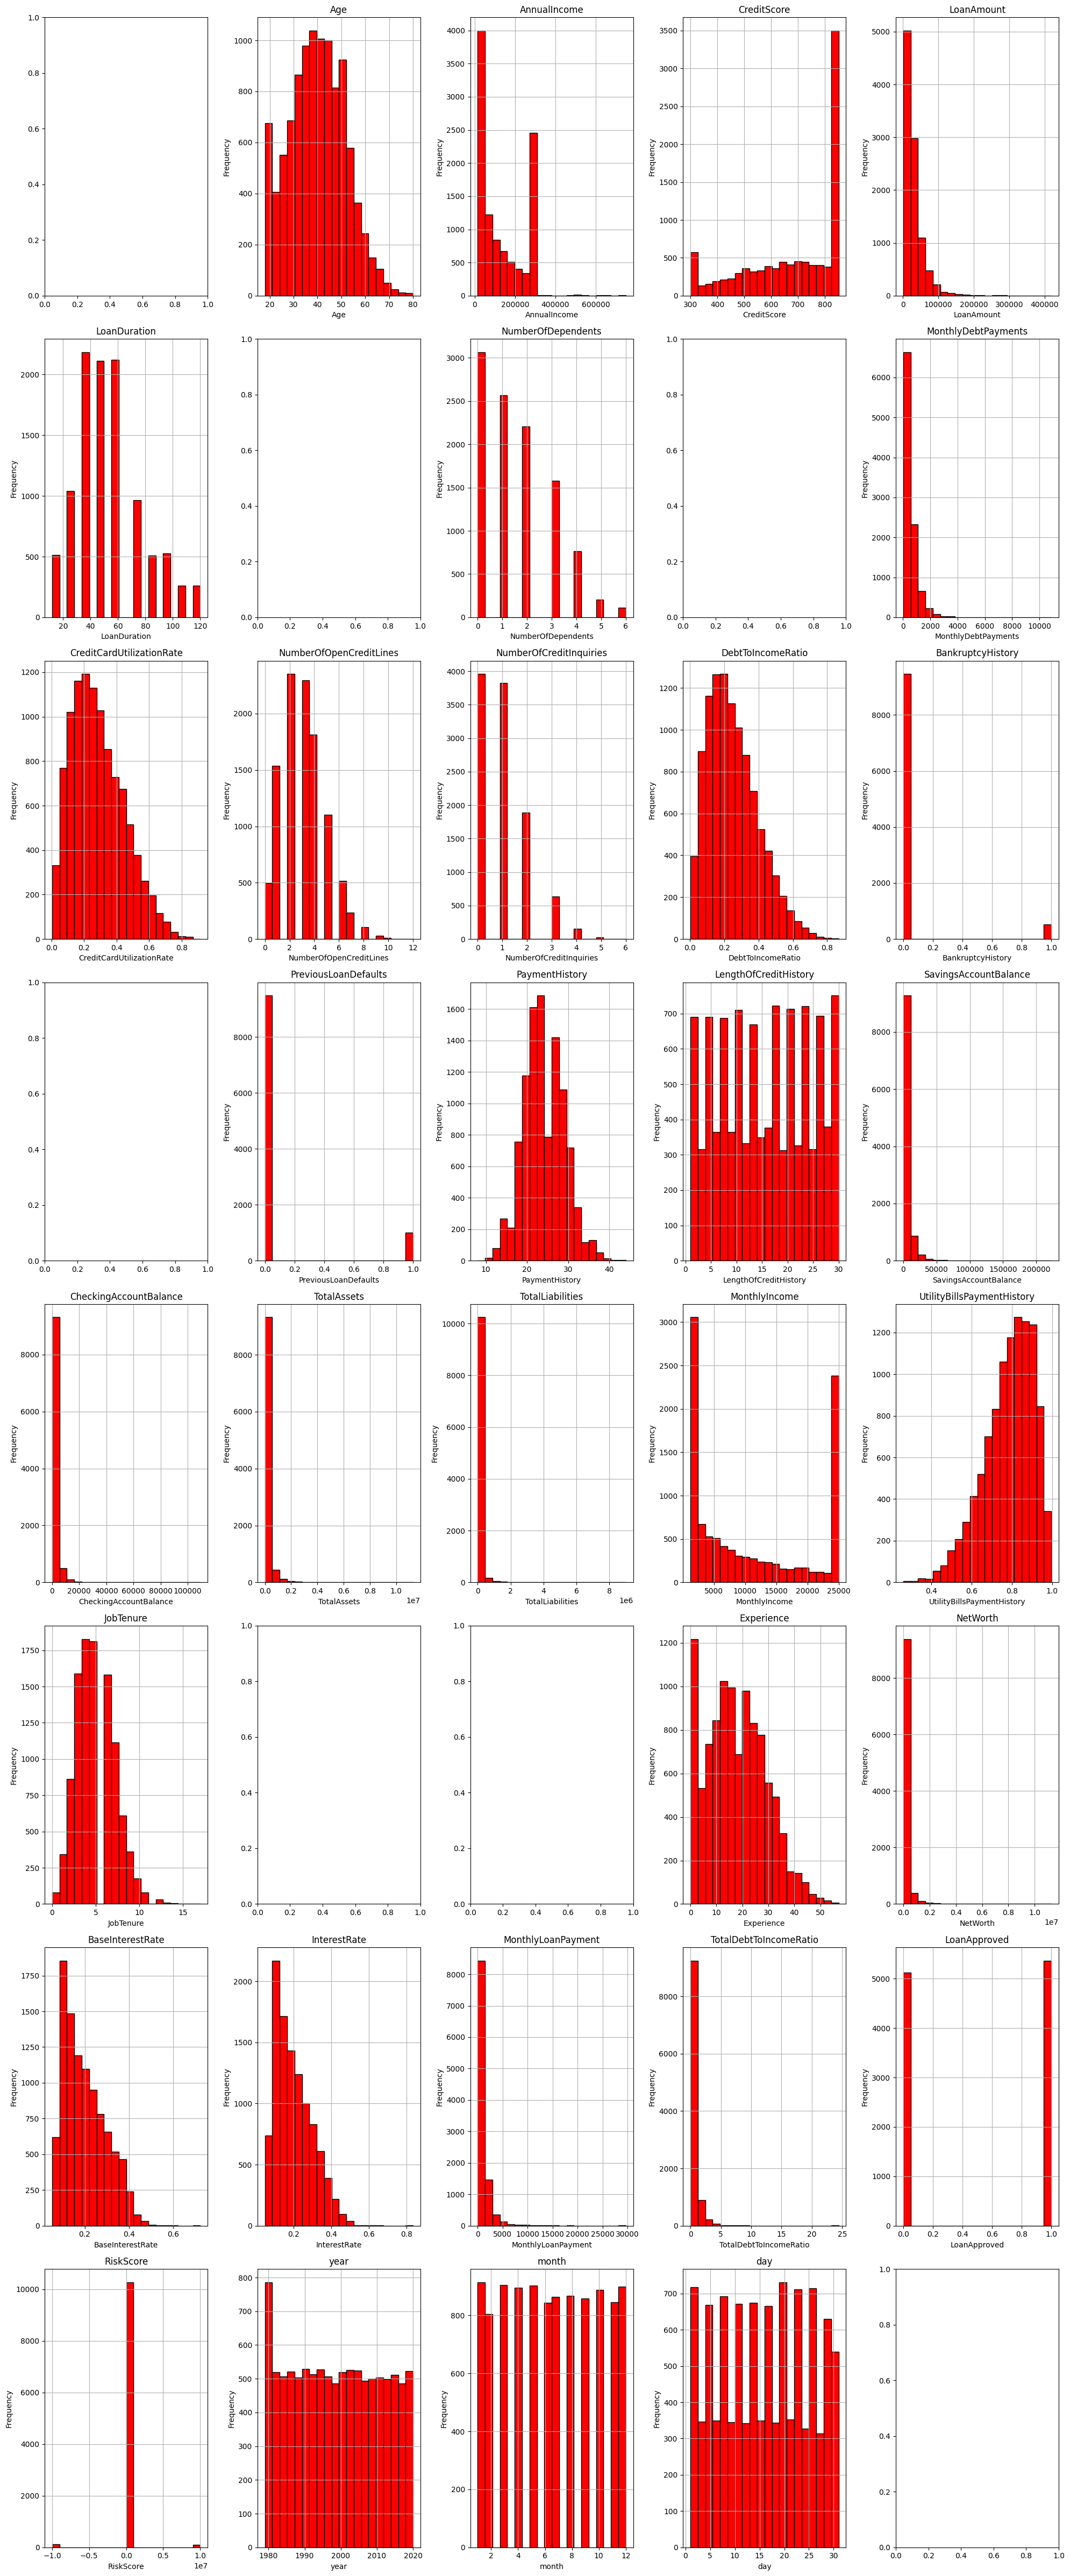

In [349]:
fig, axes = plt.subplots(nrows=8, ncols=5, figsize=(20, 48))
axes = axes.ravel()
for i, col in enumerate(df.columns):
    if pd.api.types.is_numeric_dtype(df[col]):
        df[col].hist(ax=axes[i], bins=20, color='r', edgecolor='black')
        axes[i].set_title(col)
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

Гистограммы дают понять какую нормализацию использовать.\
Если гистограммы похожа на нормальное распределение, то нужно использовать StandardScaler.\
Если гистограмма явно смещена в одну сторону, то нужно сначала прологарифмировать, потом использовать StandardScaler.\
Для остальных использовать MinMaxScaler.\
Для признаков которые уже лежат в пределах [0,1] смысла использовать нормализацию нет.

In [350]:
scalerMinMax = MinMaxScaler()
scalerStandard = StandardScaler()

def scale(df):

    standard = ['Age', 'LoanDuration', 'CreditCardUtilizationRate', 'NumberOfOpenCreditLines', 'DebtToIncomeRatio', 
                'PaymentHistory', 'UtilityBillsPaymentHistory', 'JobTenure']
    
    minmax = ['CreditScore', 'LengthOfCreditHistory', 'year', 'month', 'day']

    log = ['LoanAmount', 'MonthlyDebtPayments', 'NumberOfCreditInquiries', 'SavingsAccountBalance', 
           'CheckingAccountBalance', 'TotalLiabilities', 'NetWorth', 'TotalDebtToIncomeRatio', 'NumberOfDependents']
    
    df[standard] = scalerStandard.fit_transform(df[standard])
    df[minmax] = scalerMinMax.fit_transform(df[minmax])
    df[log] = np.log1p(df[log])
    df[log] = scalerStandard.fit_transform(df[log])

    return df

По гистограмме также видно что в RiskScore есть выбросы, которые сильно увеличат ошибку. Видно что несколько значений лежат на 1e7 и -1е7, когда остальные близки к 0 (* 1e7). Нужно учесть это в обработке данных.

In [351]:
print("Risk Score min: ", df['RiskScore'].min())
print("Risk Score max: ", df['RiskScore'].max())

Risk Score min:  -9999999.0
Risk Score max:  10000000.0


Результирующая обрабатывающая функция

In [352]:
def dataframe_preparing(df):
    df = date_refactor(df)
    df = one_hot_encoding(df)
    df = drop_corr(df)
    df = scale(df)
    df = df.dropna(how='all')
    df = df.fillna(df.median())
    df = df.drop_duplicates()
    return df

Линейная регрессия. Подбираем гиперпараметры с помощью GridSearchCV

In [353]:
from sklearn.model_selection import GridSearchCV

param_grid = {'alpha': [0.001, 0.001, 0.01, 0.1, 1, 10], 'max_iter': [1000, 5000, 10000, 50000]}

df_cleaned = dataframe_preparing(df)
df_cleaned = df_cleaned[(df_cleaned['RiskScore'] >= -100) & (df_cleaned['RiskScore'] <= 100)]

ridge = Ridge()

grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)
X = df_cleaned.drop('RiskScore', axis=1)
Y = df_cleaned['RiskScore']
grid_search.fit(X, Y)

print("Лучшие параметры:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X)

print("MSE: ", mean_squared_error(Y, y_pred))


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Лучшие параметры: {'alpha': 0.1, 'max_iter': 1000}
MSE:  20.17598401245424


Применяем на тестовой выборке

In [354]:
df_test = pd.read_csv('test.csv')
df_test = dataframe_preparing(df_test)
idx = df_test['ID']
df_test = df_test.drop('ID', axis=1)
Risk_pred = best_model.predict(df_test)

result = pd.DataFrame({
    'ID': idx,
    'RiskScore': Risk_pred
})

result.to_csv('answer.csv', index=False)